# <ins> HLoG-VBGMM:

* HLoG-VBGMM is a blob detector based on Laplacian of Gaussian for filtering, Hessian analysis for segmentation, and VBGMM for clustering. 

In [1]:
# import librairies
import SimpleITK as sitk
import numpy as np 
import matplotlib.pyplot as plt
import pandas as pd
from python.utils import get_index_matrix_3D, get_mean_value, get_R_value, get_S_value
from scipy import ndimage
from skimage.measure import label, regionprops_table
from sklearn.mixture import BayesianGaussianMixture
%matplotlib ipympl

## 1 - Import and read the data

In [2]:
# mri and mask paths
mri_path = './data/60u/con158_B_60u.nii.gz'
mask = './data/60u/con158_B_60u_mask_cortex_medulla.nii.gz'  # 0 = background; 1 = cortex; 2 = medulla

# read the .nii.gz file with simpleITK
mri = sitk.ReadImage(mri_path)
mask = sitk.ReadImage(mask)

# convert to numpy array
mri = sitk.GetArrayFromImage(mri)
mask = sitk.GetArrayFromImage(mask)

# normalisation
mri /= np.max(mri)

# use matlab format
Nz, Ny, Nx = mri.shape

# middle plan slice number (for plots) 
mid_plan = int(Nz / 2)

# parameters:
resolution = 60 # enter the resolution of the mri here 
factor = resolution / 30     
radius = 2.5 / factor
radius_min = 2.0 / factor
radius_max = 6.0 / factor
log_sigma = radius / np.sqrt(3)
vol_min = (4 / 3) * np.pi * radius_min**3 
vol_max = (4 / 3) * np.pi * radius_max**3

Text(0.5, 1.0, 'Middle plan MRI at 60-micron resolution')

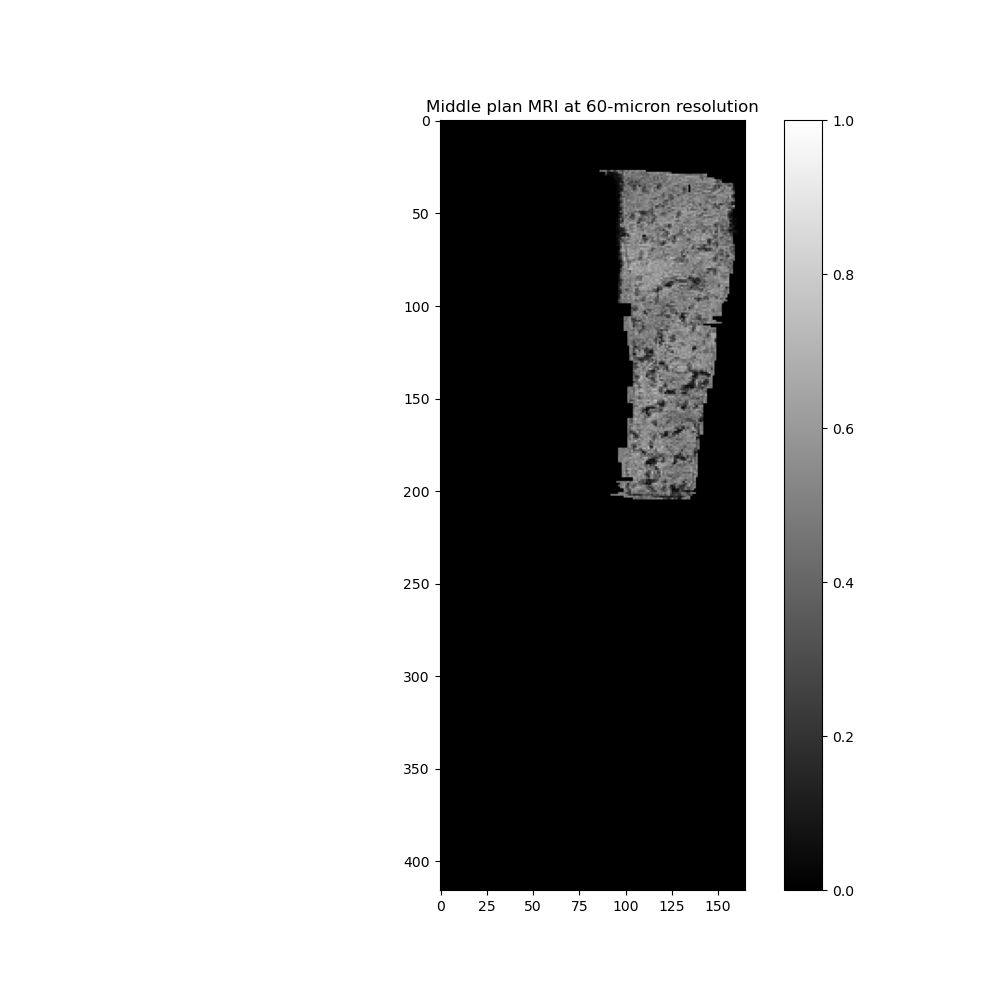

In [3]:
# quick visualisation
plt.figure(figsize=(10, 10))
plt.imshow(mri[mid_plan, :, :], vmin=0., vmax=1., cmap='gray')
plt.colorbar()
plt.title('Middle plan MRI at ' + str(resolution) + '-micron resolution')

# 2 - Hessian analysis for blob segmentation and scale optimisation

Given a 3-D image $f : \mathbb{R^3} → \mathbb{R}$, the hessian matrix of the voxel $(x, y, z)$, noted $H(x, y, z)$, is defined as:

$$ H(x, y, z) = \nabla . \nabla f(x, y, z)$$

As all the voxels of a blob have a negative definite hessian matrix, we define the binary indicator matrix $I$ such that $I(x, y, z) = 1$ if the voxel $(x, y, z)$ has a negative definte hessian matrix, and I(x, y, z) = 0 otherwise. 

Hessian analysis can also be used to identify the optimal scale parameter $\sigma$. In our case, we assume that all glomeruli have approximately the same size. As a result, we optimise a single scale parameter, unique for all blobs. To do so, we use the average LoG value of blob candidates $B_{LoG}$, defined as:

$$ B_{LoG}(\sigma) = \frac{\sum_{x, y, z} L(x, y, z; \sigma) \times I(x, y, z; \sigma)}{\sum_{x, y, z}I(x, y, z; \sigma)}$$

Finally, by iterating through a range of scales values, we obtain the optimum scale:

$$\sigma^* = \text{argmax}_{\sigma} (B_{LoG}(\sigma))$$

NB: at 30-micron, this optimisation process becomes too expensive so we suggest to use $\sigma^* = \frac{r}{\sqrt{d}}$, where $r$ is the target radius (average radius size of glomeruli in literature) and $d$ the dimension (here $d = 3$).

In [4]:
# lists to store the results: 
list_sigma = []
list_avg_score = []

# parameters
BLoG_best = -100 
n_iter = 3
step = 0.05 
min_sigma = log_sigma
max_sigma = min_sigma + n_iter * step 

# iterate through sigma values
i = min_sigma 
while (i <= max_sigma):
    # LoG filtering
    LoG_temp =  ndimage.gaussian_laplace(mri, sigma=i)

    # normalisation of LoG_temp in [-1 ; 1] for fair comparaison
    xmin = np.min(LoG_temp)
    xmax = np.max(LoG_temp)
    LoG_temp =  2 * ((LoG_temp - xmin) / (xmax - xmin)) - 1

    # get the binary index matrix (convexity map) from Hessian analysis
    I_temp, lambda1_temp, lambda2_temp, lambda3_temp = get_index_matrix_3D(im=LoG_temp, mask=mask)
        
    # calculate the average pixel value
    BLoG = (np.sum(LoG_temp * I_temp)) / np.sum(I_temp)

    # compare results and update values if the score is improved
    if BLoG > BLoG_best:
        BLoG_best = BLoG
        I = I_temp
        LoG_norm = LoG_temp 
        lambda1, lambda2, lambda3 = lambda1_temp, lambda2_temp, lambda3_temp
        
    # store the results 
    list_sigma.append(i)
    list_avg_score.append(BLoG)

    # Update sigma value
    i += step

# 3 - Features extraction


In [5]:
labels = label(I)
list_properties = ['area','bbox', 'label', 'centroid', 'EquivDiameter', 'axis_major_length', 'inertia_tensor_eigvals', 'coords']
df = pd.DataFrame(regionprops_table(labels, properties = list_properties))

# remove the blobs that are too small or too big
df = df[(df['area'] <= vol_max) & (df['area'] >= vol_min)] 
df = df.reset_index(drop=True)

# add S, R, and mean_intensity columns:
df.insert(1, "S", '')
df.insert(2, "R1", '') # To measure L1 / L3
df.insert(3, "R2", '') # To measure L2 / L3
df.insert(4, "S_max", 0)
df.insert(5, "R1_max", 0)
df.insert(6, "R2_max", 0)
df.insert(7, "S_mean", 0)
df.insert(8, "R1_mean", 0)
df.insert(9, "R2_mean", 0)
df.insert(10, "mean_intensity", 0)
for i in range(len(df)):
    # S features:
    df["S"][i] = get_S_value(lambda1, lambda2, lambda3, df["coords"][i])
    df["S_max"][i] = np.max(df["S"][i])
    df["S_mean"][i] = np.mean(df["S"][i])
    # R1 features:
    df["R1"][i] = get_R_value(lambda3, lambda1, df["coords"][i])
    df["R1_max"][i] = np.max(df["R1"][i])
    df["R1_mean"][i] = np.mean(df["R1"][i])
    # R2 features:
    df["R2"][i] = get_R_value(lambda2, lambda1, df["coords"][i])
    df["R2_max"][i] = np.max(df["R2"][i])
    df["R2_mean"][i] = np.mean(df["R2"][i])
    # mean_intensity feature:
    df["mean_intensity"][i] = get_mean_value(LoG_norm, df["coords"][i])

# FA (fractional anisotropy):
lambda_0 = df['inertia_tensor_eigvals-0']
lambda_1 = df['inertia_tensor_eigvals-1']
lambda_2 = df['inertia_tensor_eigvals-2']
FA = np.sqrt(1 / 2) * np.sqrt((lambda_0 - lambda_1)**2 + (lambda_1 - lambda_2)**2 + (lambda_2 - lambda_0)**2) / np.sqrt(lambda_0**2 + lambda_1**2 + lambda_2**2)
df.insert(11, "FA", FA)

# add std_eigvalues column to dataframe
std_eigvalues = np.std([df['inertia_tensor_eigvals-0'], df['inertia_tensor_eigvals-1'], df['inertia_tensor_eigvals-2']], axis=0)
df.insert(12, 'std_eigvalues', std_eigvalues)

/var/folders/1g/6lhzy_357n72_7qbq_2rjvsc0000gn/T/ipykernel_68233/3651426207.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["S"][i] = get_S_value(lambda1, lambda2, lambda3, df["coords"][i])
/var/folders/1g/6lhzy_357n72_7qbq_2rjvsc0000gn/T/ipykernel_68233/3651426207.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["S_max"][i] = np.max(df["S"][i])
/var/folders/1g/6lhzy_357n72_7qbq_2rjvsc0000gn/T/ipykernel_68233/3651426207.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_

Text(0.5, 0.98, 'Steps of HLoG to pre-segment blob candidates')

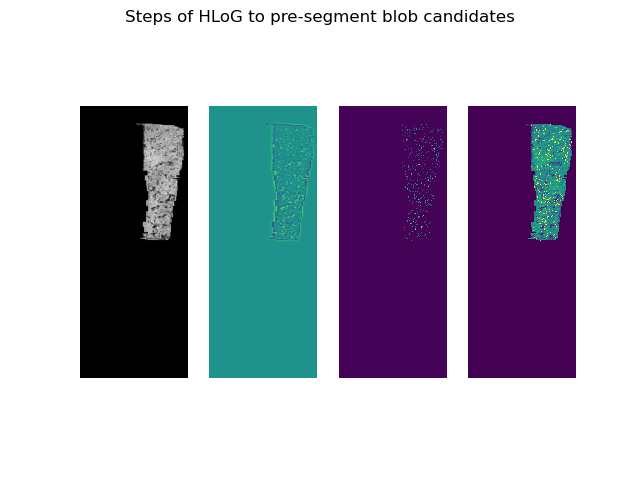

In [6]:
# counting results
count_blob_candidates = len(df)

# generate mask for blob candidates:
mask_blob = np.zeros(mri.shape)

for i in range(count_blob_candidates):
    for j in range(len(df.coords[df.index[i]])):
        x, y, z = df.coords[df.index[i]][j]
        mask_blob[(x, y, z)] = 1


# plot of HLoG steps
f, axarr = plt.subplots(1, 4)
axarr[0].imshow(mri[mid_plan, :, :], cmap="gray")
axarr[0].axis('off')
axarr[1].imshow(LoG_norm[mid_plan, :, :])
axarr[1].axis('off')
axarr[2].imshow((LoG_norm * I)[mid_plan, :, :], interpolation='nearest')
axarr[2].axis('off')
mat =  np.copy(mri)
mat[np.where(mask_blob == 1)] = 1
axarr[3].imshow(mat[mid_plan, :, :], interpolation='nearest')
axarr[3].axis('off')
plt.suptitle('Steps of HLoG to pre-segment blob candidates')

# 4 - Clustering with VBGMM

In [7]:
vbgmm = BayesianGaussianMixture(n_components=2, covariance_type='full', random_state=0).fit(df[["area", "S_max", "R1_max"]])

In [8]:
# check the mean values
print(vbgmm.means_)

[[15.75851147  0.51312203  0.4676864 ]
 [ 6.9934672   0.45113967  0.40631444]]


In [9]:
# clustering
labels_vbgmm = vbgmm.predict(df[["area", "S_max", "R1_max"]])
array_vbgmm = np.reshape(labels_vbgmm, (len(labels_vbgmm), 1))

# Add labels to dataframe:
df[["labels_vbgmm"]]= array_vbgmm

In [10]:
# score: we keep the cluster with the highest R1_max mean value:
if vbgmm.means_[0, 2] > vbgmm.means_[1, 2]:
    n_glom = count_blob_candidates - np.sum(array_vbgmm)
    n_non_glom = np.sum(array_vbgmm)
    df_glom = df[df["labels_vbgmm"] == 0]
    df_non_glom = df[df["labels_vbgmm"] == 1]
else:
    n_glom = np.sum(array_vbgmm)
    n_non_glom = count_blob_candidates - np.sum(array_vbgmm)
    df_glom = df[df["labels_vbgmm"] == 1]
    df_non_glom = df[df["labels_vbgmm"] == 0]

print("The total number of glomeruli is: " + str(n_glom))

The total number of glomeruli is: 780


/var/folders/1g/6lhzy_357n72_7qbq_2rjvsc0000gn/T/ipykernel_68233/2943019821.py:32: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot()


(-0.5, 494.5, 415.5, -0.5)

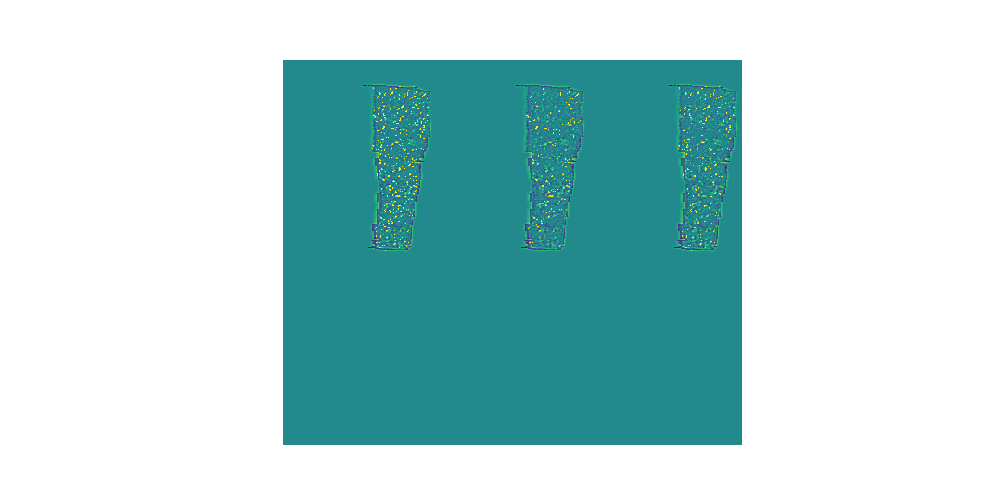

In [11]:
# generate masks and plot the segmentation result
count_glom = len(df_glom)
count_non_glom = len(df_non_glom)

# generate masks
mask_glom = np.zeros(mri.shape)
mask_non_glom = np.zeros(mri.shape)


for i in range(count_glom):
    for j in range(len(df_glom.coords[df_glom.index[i]])):
        x, y, z = df_glom.coords[df_glom.index[i]][j]
        mask_glom[(x, y, z)] = 1

for i in range(count_non_glom):
    for j in range(len(df_non_glom.coords[df_non_glom.index[i]])):
        x, y, z = df_non_glom.coords[df_non_glom.index[i]][j]
        mask_non_glom[(x, y, z)] = 1


mat1 =  np.copy(LoG_norm)
mat1[np.where(mask_blob == 1)] = 1

mat2 =  np.copy(LoG_norm)
mat2[np.where(mask_glom == 1)] = 1

mat3 =  np.copy(LoG_norm)
mat3[np.where(mask_non_glom == 1)] = 1

plot_matrix = np.concatenate((mat1, mat2, mat3), axis=2)

plt.subplot()
plt.figure(figsize=(10, 5))
plt.imshow(plot_matrix[mid_plan, :, :], interpolation='nearest')
plt.axis('off')